In [80]:
from copy import copy
import random
import numpy as np
import matplotlib.pyplot as plt

## Some useful constants

In [103]:
NORTH_PROB = 0.99

## Define the env

In [104]:
class TrafficLightEnv():
    def __init__(self, car_arrival_prob=0.75, max_queue_size=10):
        self.car_arrival_prob = car_arrival_prob
        self.max_queue_size = max_queue_size
        
    def reset(self):
        return [0, 0, 'N']
        
    def step(self, state, action):
            old_state = copy(state)
            q_0, q_1, direction = state
            new_state = (q_0, q_1, direction)
        
            # Handle car departures based on the current direction
            if direction == 'N' and action == 'No-Op':
                departed_cars = min(q_0, 2)
                q_0 = max(q_0 - departed_cars, 0)
            elif direction == 'E' and action == 'No-Op':
                departed_cars = min(q_1, 2)
                q_1 = max(q_1 -departed_cars, 0)
            
            # Switch direction if action is to switch
            if action == 'Switch':
                direction = 'E' if direction == 'N' else 'N'
                
            # compute the rewards before cars arrive
            new_state = (q_0, q_1, direction)
            reward = self.reward(old_state, new_state)
            
            # Handle car arrivals probabilistically
            if random.random() < self.car_arrival_prob:
                if q_0 < self.max_queue_size: q_0 += 1
            else:
                if q_1 < self.max_queue_size: q_1 += 1
            
            # Update state after cars arrive
            new_state = (q_0, q_1, direction)
        
            return new_state, reward
        
    def reward(self, curr_state, next_state):
        """The reward is +1 for each departed car, -1 for each queue greater than 5"""
        north_reward = max(curr_state[0] - next_state[0], 0)
        east_reward = max(curr_state[1] - next_state[1], 0)
        north_penalty = -1 if next_state[0] > 5 else 0
        east_penalty = -1 if next_state[1] > 5 else 0
        return north_reward + east_reward + north_penalty + east_penalty
        
        

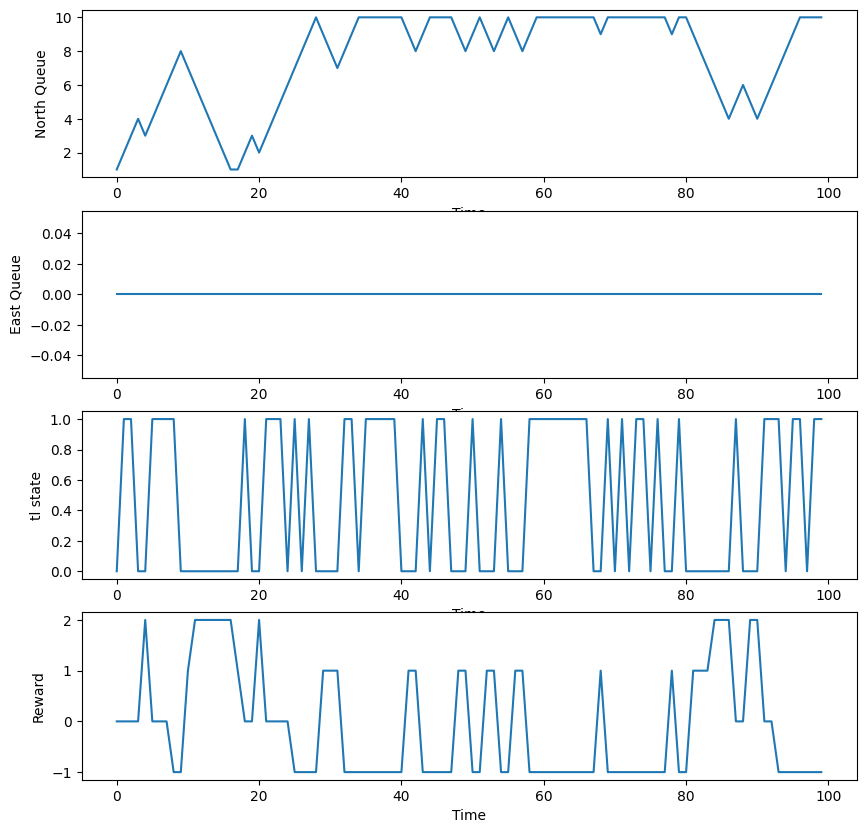

In [105]:
# Lets do a random rollout and visualize the length of each of the queues and the reward
# as a function of time
episode_length = 100
max_queue_size = 10
env = TrafficLightEnv(car_arrival_prob=NORTH_PROB, max_queue_size=max_queue_size)
state = env.reset()
states = np.zeros((episode_length, 2))
tl_state = np.zeros(episode_length)
rewards = np.zeros(episode_length)
for t in range(episode_length):
    action = random.choice(['No-Op', 'Switch'])
    state, reward = env.step(state, action)
    states[t, 0] = state[0]
    states[t, 1] = state[1]
    tl_state[t] = 1 if state[2] == 'E' else 0
    rewards[t] = reward
    
# plot the queues on one plot and then the rewards on another
# in a grid
fig, ax = plt.subplots(4, 1, figsize=(10, 10))
ax[0].plot(states[:, 0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('North Queue')

ax[1].plot(states[:, 1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('East Queue')
# ax[0].legend(['Queue 0', 'Queue 1'])

ax[2].plot(tl_state)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('tl state')

ax[3].plot(rewards)
ax[3].set_xlabel('Time')
ax[3].set_ylabel('Reward')
plt.show()


## I'm too lazy to write out the transition functions, so lets compute them by sampling

In [106]:
# the elements of the transition matrix are the probabilities of transitioning from one state to another
# the transition matrix is a 7-dimensional array, with the first 3 dimensions representing the current state
# the fourth dimension representing the action
# and the last 3 dimensions representing the next state
transition_probs = np.zeros((max_queue_size + 1, 
                             max_queue_size + 1, 
                             2, 
                             2,
                             max_queue_size + 1,
                             max_queue_size + 1, 
                             2))
num_rollouts = 500
env = TrafficLightEnv(car_arrival_prob=NORTH_PROB)
for i in range(num_rollouts):
    state = env.reset()
    for t in range(100):
        action = random.choice(['No-Op', 'Switch'])
        new_state, reward = env.step(state, action)
        transition_probs[state[0], state[1], 0 if state[2] == 'N' else 1, 
                         0 if action == 'No-Op' else 1, 
                         new_state[0], new_state[1], 0 if new_state[2] == 'N' else 1] += 1
        state = new_state
# now we need to normalize the transition probabilities
# normally we would vectorize this but it's clearer to write it out
for q_0 in range(11):
    for q_1 in range(11):
        for direction in range(2):
            for action in range(2):
                if transition_probs[q_0, q_1, direction, action].sum() > 0:
                    transition_probs[q_0, q_1, direction, action] /= transition_probs[q_0, q_1, direction, action].sum()

## Lets look at an example transition probability

In [107]:
# this is no cars in either direction, Green facing north
# we ask for the action to switch and then ask what is the 
# probability that the next state will be 0, 1, 'E'
# it should be around 0.25!
transition_probs[0, 0, 0, 1, 0, 1, 1]

0.007722007722007722

## Now lets compute the value and policy by value iteration

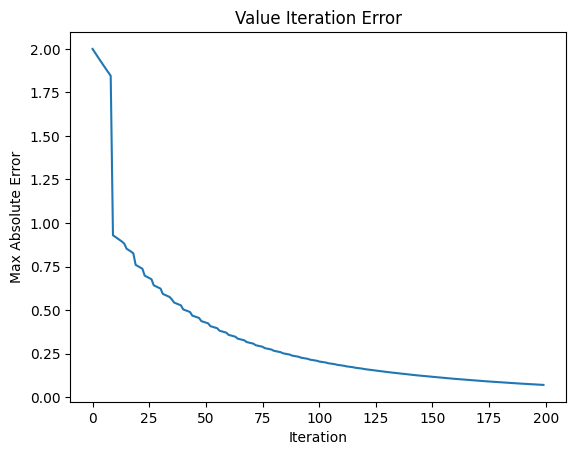

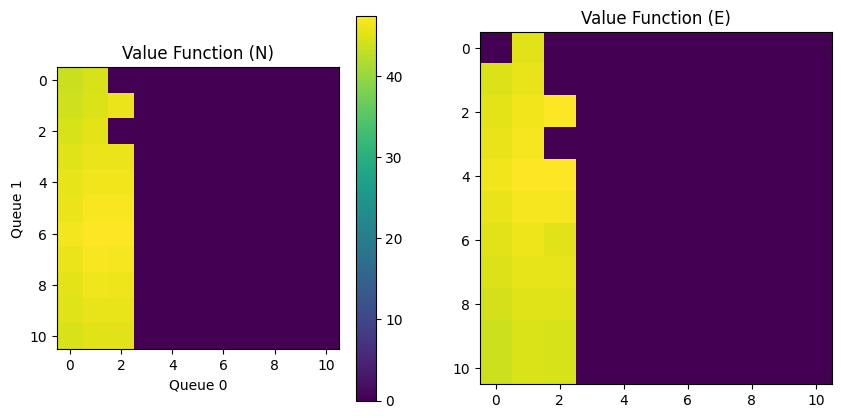

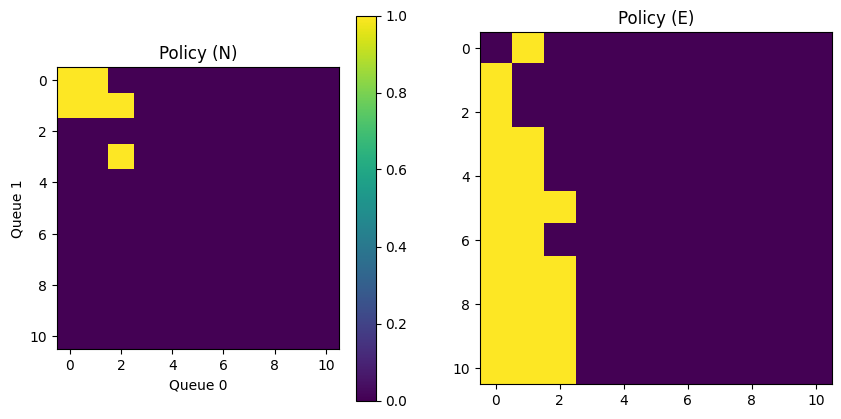

In [114]:
# okay, now we can run value iteration 
discount = 0.99
epsilon = 0.001
value = np.zeros((max_queue_size + 1, max_queue_size + 1, 2))
policy = np.zeros((11, 11, 2))
observed_error = []
for i in range(200):
    new_value = np.zeros((max_queue_size + 1, max_queue_size + 1, 2))
    for x in range(max_queue_size + 1):
        for y in range(max_queue_size + 1):
            for curr_direction in range(2):
                best_action = 0
                best_value = -np.inf
                for a in range(2):
                    action_value = 0 # Corrected variable name
                    for next_x in range(max_queue_size + 1):
                        for next_y in range(max_queue_size + 1):
                            for next_direction in range(2):
                                action_value += transition_probs[x, y, curr_direction, a, next_x, next_y, next_direction] * \
                                  (env.reward((x, y, curr_direction), (next_x, next_y, next_direction)) \
                                    + discount * value[next_x, next_y, next_direction]) # Use value for discounted future values
                    if action_value > best_value:
                        best_value = action_value
                        best_action = a
                new_value[x, y, curr_direction] = best_value
                policy[x, y, curr_direction] = best_action
    if np.abs(new_value - value).max() < epsilon:
        break
    else:
        observed_error.append(np.abs(new_value - value).max())
    value = new_value # Correctly update value array after each iteration

# plot the error over time
plt.figure()
plt.plot(observed_error)
plt.title('Value Iteration Error')
plt.xlabel('Iteration')
plt.ylabel('Max Absolute Error')
plt.show()

# Lets also plot the value function as a heatmap for each direction
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(value[:, :, 0])
ax[0].set_title('Value Function (N)')
ax[1].imshow(value[:, :, 1])
ax[1].set_title('Value Function (E)')
# add some x and y labels
ax[0].set_xlabel('Queue 0')
ax[0].set_ylabel('Queue 1')
# add a vertical plot indicating what the colors mean
plt.colorbar(ax[0].imshow(value[:, :, 0]), ax=ax[0])
plt.show()

# Finally lets plot the policy at each state
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(policy[:, :, 0])
ax[0].set_title('Policy (N)')
ax[1].imshow(policy[:, :, 1])
ax[1].set_title('Policy (E)')
# add some x and y labels
ax[0].set_xlabel('Queue 0')
ax[0].set_ylabel('Queue 1')
# add a vertical plot indicating what the colors mean
plt.colorbar(ax[0].imshow(policy[:, :, 0]), ax=ax[0])
plt.show()

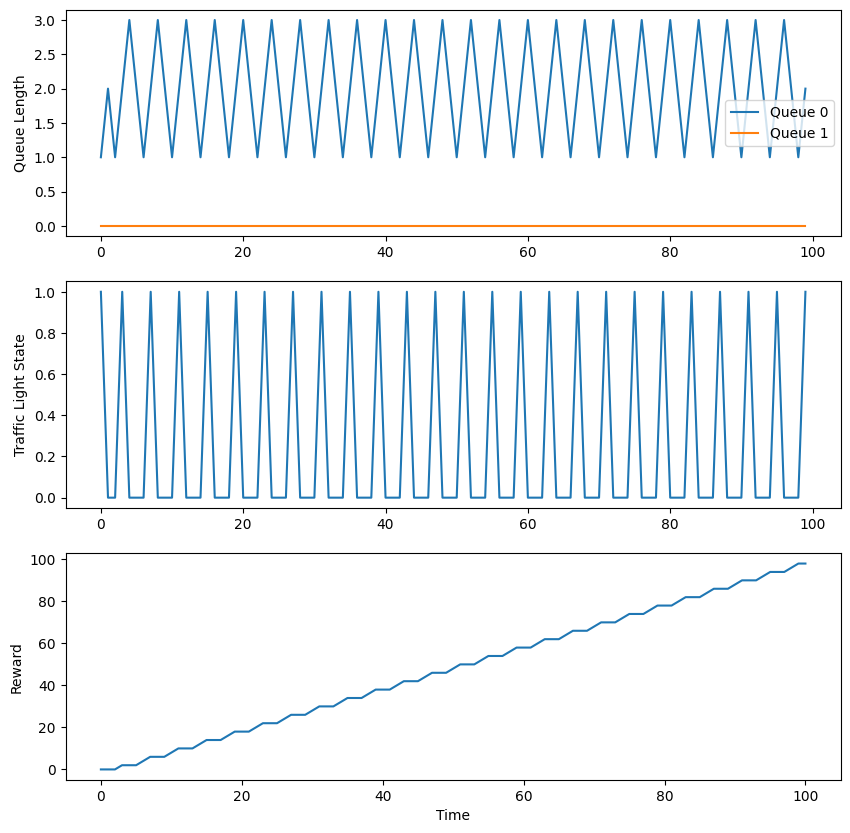

In [115]:
# okay now lets run the policy and see how it goes!
# Lets do a rollout and visualize the length of each of the queues and the reward
# as a function of time
episode_length = 100
max_queue_size = 10
env = TrafficLightEnv(car_arrival_prob=NORTH_PROB, max_queue_size=max_queue_size)
state = env.reset()
states = np.zeros((episode_length, 3))
rewards = np.zeros(episode_length + 1)
    
for t in range(episode_length):
    action = ['No-Op', 'Switch'][int(policy[state[0], state[1], 0 if state[2] == 'N' else 1])]
    new_state, reward = env.step(state, action)
    states[t, 0] = new_state[0]
    states[t, 1] = new_state[1]
    states[t, 2] = 1 if new_state[2] == 'E' else 0
    rewards[t + 1] = reward + rewards[t]
    state = new_state
    
# plot the queues on one plot and then the rewards on another
# in a grid
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(states[:, :2])
ax[0].set_ylabel('Queue Length')
ax[0].legend(['Queue 0', 'Queue 1'])

# plot the tl states
ax[1].plot(states[:, 2])
ax[1].set_ylabel('Traffic Light State')

ax[2].plot(rewards)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Reward')
plt.show()

In [116]:
# how often does the traffic light face east
states[:, 2].sum() / len(states[:, 2])

0.26